<img src="https://prnewswire2-a.akamaihd.net/p/1893751/sp/189375100/thumbnail/entry_id/1_su9da4fu/def_height/1001/def_width/1911/version/100011/type/2/q/100"  width="300" height="200">

# Data Preparation

Let's create a road map to guide us through preparation.
1. Handle missing values
1. Cast data types
1. Rename columns
1. Visualize distributions of features

In [344]:
# Import libraries for cleaning data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import functions to acquire data and visualize missing values.
from acquire import get_zillow_data
from prepare import handle_missing_values, missing_values_summary

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

In [345]:
# Let's use the function we created in acquisition to acquire the data.
# assign the data to a dataframe
df = get_zillow_data()

What's the shape of our data?

In [346]:
print(f"There are {df.shape[0]} unique properties and {df.shape[1]} features.")

There are 52439 unique properties and 68 features.


# Handle Missing Values
1. Missing Values Summary
2. Drop columns with 100% of values missing
3. Salvage columns with 80-99.99% of values missing
> Repeat until all columns that have a missing value have been dropped or salvaged.

Let's look at the features of our dataset.

## Missing Values Summary

In [347]:
# Use a function to calculate missing value stats of the data.
df_missing = missing_values_summary(df)

In [348]:
missing_summary = (
    df_missing
    .sort_values(by=['num_rows_missing']
                 ,ascending=False)
                  )

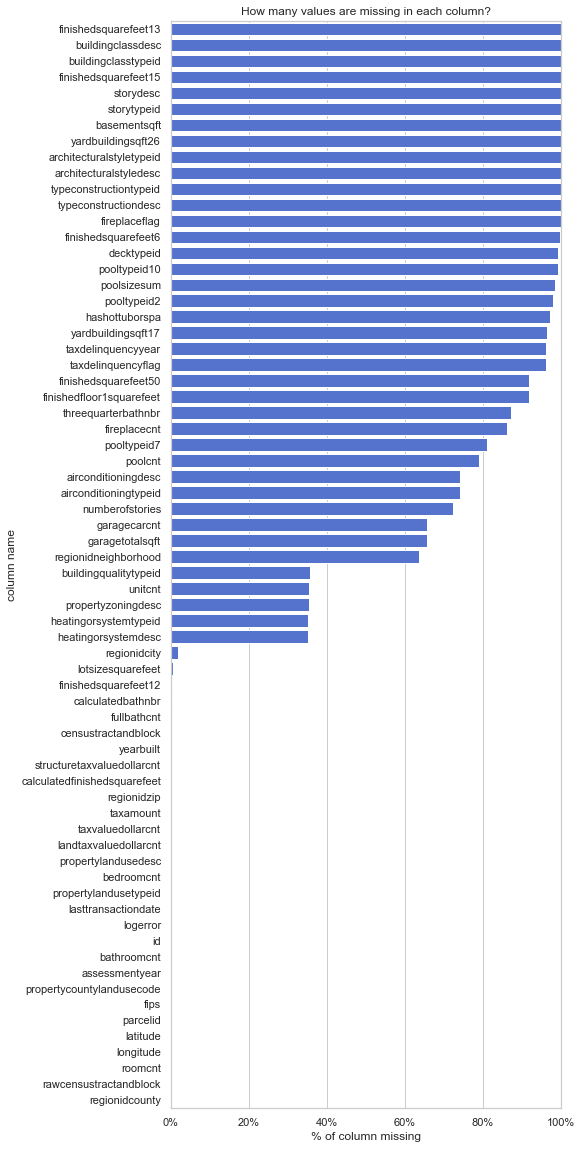

In [349]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 20))

sns.barplot(
    
    y='attribute',
    x='pct_rows_missing',
    data=missing_summary,
    orient='h',
    color='Royalblue',
)

plt.title('How many values are missing in each column?')
plt.xlabel('% of column missing')
plt.ylabel('column name')

plt.xticks(
    
    ticks=np.linspace(0, 1, 6),
    labels=['0%', '20%', '40%', '60%', '80%', '100%']
)

plt.xlim(0, 1)
plt.show()

More than half of our columns are missing a data point. Let's drop the columns that are missing between 80 and 100% of their values.
> We can't impute values if we don't have values to impute.

# Columns with 100% of Values Missing

In [350]:
# Let's start with 100% missing columns

features_100pct_missing = list(df_missing[df_missing.pct_rows_missing == 1] \
                               .attribute.values)

df_missing = df_missing[df_missing.pct_rows_missing != 1]

In [351]:
features_100pct_missing

['buildingclasstypeid',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'buildingclassdesc']

In [352]:
# drop columns from our original dataframe
df.drop(columns=features_100pct_missing, inplace=True)

# Columns with 80-99.99% of Values Missing

Before we drop columns with greater than 80% of values let's take a look at their values to see if we can salvage them.

In [353]:
df_missing[df_missing.pct_rows_missing > .9]

,attribute,num_rows_missing,pct_rows_missing
0,typeconstructiontypeid,52363,0.998551
1,storytypeid,52392,0.999104
5,architecturalstyletypeid,52369,0.998665
9,basementsqft,52392,0.999104
14,decktypeid,52050,0.992582
15,finishedfloor1squarefeet,48060,0.916493
20,finishedsquarefeet50,48060,0.916493
21,finishedsquarefeet6,52274,0.996853
27,hashottuborspa,50924,0.971109
32,poolsizesum,51572,0.983467


## Salvage features

- Matching {typeid: typedesc} columns
- Pool columns (including `has hot tub or spa`)
- Finished sqft columns
- Yard building sqft columns
- Fire place
- Tax delinquincy columns


### Matching {typeid: typedesc} columns
1. `typeconstructiontypeid` : `typeconstructiondesc`
2. `storytypeid` : `storydesc`
3. `architecturalstyletypeid` : `architecturalstyledesc`

In [354]:
# drop this column
pd.crosstab(df.typeconstructiontypeid,
            df.typeconstructiondesc)

typeconstructiondesc,Concrete,Frame
typeconstructiontypeid,,
4.0,1,0
6.0,0,75


Type of story a has property: Multilevel, Attic, Basement, etc. This is the only value in `storydesc`, let's rename it `has_basement` with values 0/1. Where 0 == no basement, 1 == basement

In [355]:
pd.crosstab(df.storytypeid,
            df.storydesc)

storydesc,Basement
storytypeid,
7.0,47


Note: If we had an ml algorithm that could utilize google images, we could infer the architectural style for every property. :O or infer the architectural style using clustering! (If we had more values...)

In [356]:
# drop this column
pd.crosstab(df.architecturalstyletypeid,
            df.architecturalstyledesc)

architecturalstyledesc,Bungalow,Cape Cod,Contemporary,Conventional,Ranch/Rambler
architecturalstyletypeid,,,,,
2.0,2,0,0,0,0
3.0,0,3,0,0,0
7.0,0,0,62,0,0
8.0,0,0,0,1,0
21.0,0,0,0,0,2


##### Matching {typeid: typedesc} columns Summary
Colums to keep:
- `storytypeid` and `storydesc`
    - Create a new column called `has_basement` where: 0 == no basement, 1 == basement
        - Drop both columns after columns after creating the new column.

Columns to drop:
- `typeconstructiontypeid`
- `typeconstructiondesc`
- `architecturalstyletypeid`
- `architecturalstyle`

### Pool columns (including hot tub/spa)

The only value in `hashottuborspa` is 1. Let's rename it `has_hottub_or_spa` with values 0/1.<br>
Where 0 == no hottub or spa, 1 == hot tub or spa

In [357]:
df.hashottuborspa.value_counts()

1.0    1515
Name: hashottuborspa, dtype: int64

Each pool column has a unique value of 1, one swimming pool. `poolcnt` has the least amount of missing values. Let's salvage it. Rename `poolcnt` as `has_pool`.
<br>Where 0 == no pool, 1 == pool

In [384]:
print(df.poolcnt.value_counts(), end='\n\n')

# drop these columns
print(df.pooltypeid2.value_counts(), end='\n\n')
print(df.pooltypeid7.value_counts(), end='\n\n')
print(df.pooltypeid10.value_counts(), end='\n')

1.0    11096
Name: poolcnt, dtype: int64

1.0    1071
Name: pooltypeid2, dtype: int64

1.0    10009
Name: pooltypeid7, dtype: int64

1.0    444
Name: pooltypeid10, dtype: int64


Of properties that have pools, there are 262 unique pool sizes. Let's take a look at the distribution of pool sizes.

Possible formula: Length x width x depth x 7.5 = volume (in gallons)
[source](https://www.google.com/search?client=firefox-b-1-d&sxsrf=ALeKk00ino43wOcQvlmUIn3tXYXnkONpgQ%3A1603077609848&ei=6QWNX5ejM4qGtQWujaL4AQ&q=how+to+calculate+the+size+of+a+swimming+pool&oq=how+to+calculate+the+size+of+a+sw&gs_lcp=CgZwc3ktYWIQAxgAMggIIRAWEB0QHjIICCEQFhAdEB4yCAghEBYQHRAeMggIIRAWEB0QHjIICCEQFhAdEB4yCAghEBYQHRAeMggIIRAWEB0QHjIICCEQFhAdEB4yCAghEBYQHRAeMggIIRAWEB0QHjoECAAQRzoHCCMQ6gIQJzoFCAAQkQI6CwguELEDEMcBEKMCOggILhDHARCjAjoICC4QsQMQgwE6AggAOggIABCxAxCDAToFCAAQsQM6BAgjECc6BwgAELEDEEM6BAgAEEM6CAgAEMkDEJECOgcIABAUEIcCOgsILhCxAxDJAxCTAjoHCCMQsQIQJzoHCAAQyQMQCjoECAAQCjoFCAAQyQM6CggAEMkDEBQQhwI6BggAEBYQHlCa-D5Y4r4_YP_IP2gFcAJ4AIABcYgBnRSSAQQzNS4ymAEAoAEBqgEHZ3dzLXdperABCsgBCMABAQ&sclient=psy-ab)

In [385]:
print(df.poolsizesum.nunique())

262


In [377]:
df[['poolsizesum']].describe().T

,count,mean,std,min,25%,50%,75%,max
poolsizesum,867.0,518.318339,156.468209,24.0,424.5,500.0,600.0,1500.0


In [397]:
pd.cut(df.poolsizesum, 4).value_counts(dropna=False)

NaN                 51572
(393.0, 762.0]        672
(22.524, 393.0]       133
(762.0, 1131.0]        59
(1131.0, 1500.0]        3
Name: poolsizesum, dtype: int64

In [396]:
df.poolsizesum.quantile(0)

24.0

In [394]:
df.poolsizesum.quantile(.25)

424.5

In [390]:
pd.qcut(df.poolsizesum, 5).value_counts()

(400.4, 450.0]     179
(23.999, 400.4]    174
(450.0, 525.0]     172
(630.0, 1500.0]    171
(525.0, 630.0]     171
Name: poolsizesum, dtype: int64

##### Pool columns (including hot tub/spa) Summary
Colums to keep:
> Drop these columns once the new ones are created.
- `hashottuborspa`
    - Create a new column called `has_hot_or_spa` with the values 0/1.<br>Where: 0 == no hottub or spa, 1 == hot tub or spa
- `poolcnt`
    - Create a new column called `has_pool`.<br>
    Where: 0 == no pool, 1 == pool

Columns to drop:
- `pooltypeid2`
- `pooltypeid7`
- `pooltypeid10`
- `pooltypeid2`

# Appendix

In [402]:
# Iteration #2 Figure out what the codes mean, Mason.
df.groupby(by='fips').propertycountylandusecode.value_counts()

fips    propertycountylandusecode
6037.0  0100                         25996
        0101                          6080
        100                            786
        0104                           349
        101                            333
        010G                            94
        0103                            89
        0108                            56
        010M                            53
        104                             20
        0109                            18
        0110                             6
        0113                             6
        0141                             4
        0102                             3
        0105                             3
        103                              2
        010V                             2
        0111                             2
        0130                             2
        108                              1
        010L                             1
        0114        

In [404]:
df.groupby(by=['fips', ).poolsizesum.value_counts()

fips    poolsizesum
6111.0  450.0          89
        400.0          38
        500.0          30
        600.0          27
        512.0          25
        800.0          25
        480.0          19
        544.0          14
        576.0          14
        360.0          13
        420.0          12
        448.0          12
        510.0          11
        525.0          11
        648.0          10
        300.0           9
        540.0           9
        640.0           9
        700.0           9
        720.0           9
        560.0           8
        680.0           8
        405.0           7
        435.0           7
        550.0           7
        375.0           6
        380.0           6
        410.0           6
        612.0           6
        650.0           6
        684.0           6
        240.0           5
        350.0           5
        390.0           5
        456.0           5
        504.0           5
        520.0           5
        578.0     